In [ ]:
# Necessary Imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Load in data
def load_data(file_path, skiprows):
    df = pd.read_csv(file_path, skiprows=skiprows, dtype=str)
    df.columns = df.columns.str.strip()
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    df = df[~df.iloc[:, 0].str.contains("Average", na=False)]
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%Y%m%d', errors='coerce')
    df = df.dropna(subset=[df.columns[0]])
    df.set_index(df.columns[0], inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df[df == -99.99] = np.nan

    return df

# File paths
industry_file = "/industry.csv"
market_file = "/market.CSV"

# Load the data with the correct number of rows to skip
industry_returns = load_data(industry_file, skiprows=9)
market_returns = load_data(market_file, skiprows=4)

# Small erroneous fix
market_returns.index = pd.to_datetime(market_returns.index, errors='coerce')

# Replace -99.99 with NaN in the industry returns data
industry_returns.replace(-99.99, np.nan, inplace=True)

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



Compute the Betas.

In [ ]:
# Compute CAPM Betas
def compute_beta(industry_returns, market_returns):
    combined_returns = industry_returns.join(market_returns, how='inner', rsuffix='_Mkt')
    monthly_betas = {}

    for industry in industry_returns.columns:
        monthly_betas[industry] = combined_returns.groupby(combined_returns.index.to_period('M')).apply(
            lambda x: np.cov(x[industry], x['Mkt-RF'])[0, 1] / np.var(x['Mkt-RF']) if len(x) > 1 else np.nan
        )

    return pd.DataFrame(monthly_betas)

monthly_betas = compute_beta(industry_returns, market_returns)

Graph the Betas

In [ ]:
# Convert the index to datetime to resolve the 'Period' issue
monthly_betas.index = monthly_betas.index.to_timestamp()

# Create the figure for Monthly Betas
fig = go.Figure()

for industry in monthly_betas.columns:
    fig.add_trace(go.Scatter(x=monthly_betas.index, y=monthly_betas[industry], mode='lines', name=industry))

fig.update_layout(
    title="Monthly CAPM Betas of 49 Industries",
    xaxis_title="Time",
    yaxis_title="Beta",
    template="plotly_dark",
    height=600,
    width=800
)

fig.show()

Compute the Volatility.

In [ ]:
# Compute CAPM Volatilities
def compute_volatility(industry_returns):
    return industry_returns.groupby(industry_returns.index.to_period('M')).std() * 100

monthly_volatilities = compute_volatility(industry_returns)
monthly_volatilities.index = monthly_volatilities.index.to_timestamp()

Principal Component Analysis comparison between the betas and volatility. Working hypothesis: the cumulative explained variance for volatility will be stronger than the betas.

In [ ]:
# Perform PCA on Betas
pca = PCA()
pca.fit(monthly_betas.dropna())
explained_variance = pca.explained_variance_ratio_

# Perform PCA on Volatility
pca_volatility = PCA()
pca_volatility.fit(monthly_volatilities.dropna())
explained_variance_volatility = pca_volatility.explained_variance_ratio_

In [ ]:
# Create the figure for PCA Beta Cumulative Explained Variance
fig_pca = go.Figure()

fig_pca.add_trace(go.Scatter(
    x=list(range(1, len(explained_variance) + 1)),
    y=np.cumsum(explained_variance),
    mode='lines+markers',
    name='Cumulative Explained Variance'
))

fig_pca.update_layout(
    title="PCA of Monthly CAPM Betas",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Explained Variance",
    template="plotly_dark",
    height=500,
    width=800
)

fig_pca.show()

# Create the figure for PCA Volatility Cumulative Explained Variance
fig_pca_volatility = go.Figure()
fig_pca_volatility.add_trace(go.Scatter(
    x=list(range(1, len(explained_variance_volatility) + 1)),
    y=np.cumsum(explained_variance_volatility),
    mode='lines+markers',
    name='Cumulative Explained Variance'
))
fig_pca_volatility.update_layout(
    title="PCA of Monthly Industry Volatilities",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Explained Variance",
    template="plotly_dark",
    height=500,
    width=800
)
fig_pca_volatility.show()

Extracting Principal Components and Constructing a Correlation Matrix

In [ ]:
# Perform PCA on Industry Betas and Industry Volatilities
pca_betas = PCA()
pca_vols = PCA()
pca_betas.fit(monthly_betas.dropna())
pca_vols.fit(monthly_volatilities.dropna())

PCA()

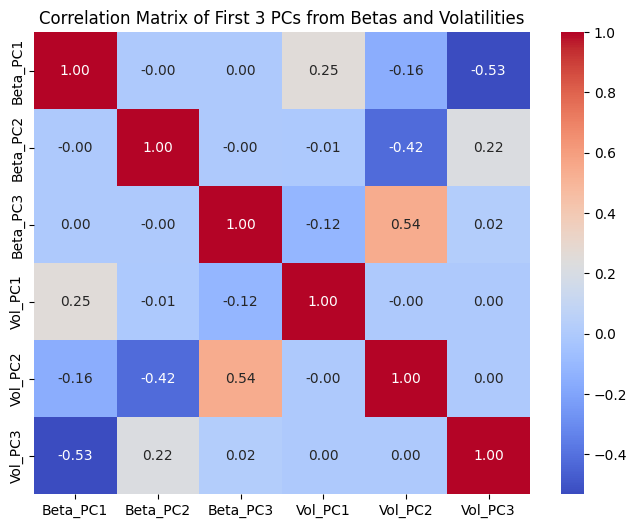

In [ ]:
# Extract first 3 Principal Components from both analyses
pca_betas_components = pd.DataFrame(pca_betas.transform(monthly_betas.dropna()))
pca_vols_components = pd.DataFrame(pca_vols.transform(monthly_volatilities.dropna()))

# Select first 3 PCs from each
pca_betas_3 = pca_betas_components.iloc[:, :3]
pca_vols_3 = pca_vols_components.iloc[:, :3]

# Construct Correlation Matrix of 6 Principal Components
pca_combined = pd.concat([pca_betas_3, pca_vols_3], axis=1)
pca_combined.columns = ['Beta_PC1', 'Beta_PC2', 'Beta_PC3', 'Vol_PC1', 'Vol_PC2', 'Vol_PC3']
correlation_matrix = pca_combined.corr()

# Plot Correlation Matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of First 3 PCs from Betas and Volatilities")
plt.show()